In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('experiment/2004-01'), '..', '..','..')))
from stacking import *
import time
from helper_code import find_data_folders
from sklearn.model_selection import train_test_split


In [2]:
# Define the data and model folder
data_folder = "../data/labels"
model_folder = "models"

In [3]:
# split train/ test
patient_ids = find_data_folders(data_folder)
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
print('Number of test patients: ', len(test_ids))

Number of test patients:  2


### TRAIN MODEL DENSENET121

In [4]:
print("Start train model")
start_time_train_model = time.time()
verbose = 1

train_challenge_model(data_folder, model_folder, train_ids, verbose) 

print(f"Finished running train_model.py in {round((time.time() - start_time_train_model)/60, 2)} minutes.")

Start train model
Load model...
Loading checkpoint from models/densenet121.pth
Using densenet121 model from scratch
model_name:  densenet121
Load model...
Loading checkpoint from models/resnet50.pth
Using resnet50 model from scratch
model_name:  resnet50
Load model...
Loading checkpoint from models/efficientnet_v2_s.pth
Using efficientnet_v2_s model from scratch
model_name:  efficientnet_v2_s
Load model...
Loading checkpoint from models/convnext_tiny.pth
Using convnext_tiny model from scratch
model_name:  convnext_tiny
Meta-model training score: 1.0000
Meta-model validation score: 1.0000
Saved meta-model to models/meta_model.sav
Finished running train_model.py in 0.47 minutes.


### RUN MODEL DENSENET121

In [5]:
import pandas as pd
import numpy as np, scipy as sp, os, sys
from tqdm import tqdm
import time
from helper_code import *
from stacking import run_challenge_model

In [6]:
output_filename = 'stacking.csv'
output_folder = 'results'

In [7]:

def run_model(model_folder, data_folder, output_folder,patient_ids,  allow_failures, verbose):
    if verbose >= 1:
        print('Loading the Challenge models...')


    # Find the Challenge data.
    if verbose >= 1:
        print('Finding the Challenge data...')

    num_patients = len(patient_ids)

    if num_patients==0:
        raise Exception('No data were provided.')


    os.makedirs(output_folder, exist_ok=True)


    if verbose >= 1:
        print('Running the Challenge models on the Challenge data...')
    prediction_results = []
    for i in tqdm(range(num_patients)):
        print(f"[{i}/{num_patients}]")
       

        patient_id = patient_ids[i]
        print('PATIENT ID: ', patient_id )
        file_meta_data = os.path.join(data_folder, patient_id, f"{patient_id}.txt")
        meta_data = load_text_file(file_meta_data)
        actual_outcome = get_variable(meta_data, 'Outcome', str)
        actual_cpc = get_cpc(meta_data)

        # Allow or disallow the model(s) to fail on parts of the data; this can be helpful for debugging.
        try:
            outcome_binary, outcome_probability = run_challenge_model(model_folder, data_folder, patient_id, verbose) ### Teams: Implement this function!!!
            print("Predict outcome: ", "Good" if sanitize_boolean_value(outcome_binary) == 0 else "Poor", " - Actual outcome: ", actual_outcome)
            
            prediction_results.append({
                'patient_id': patient_id,
                'outcome_binary': outcome_binary,
                'outcome_prob': outcome_probability, 
                'actual_outcome': actual_outcome,
            })
            
        except:
            if allow_failures:
                if verbose >= 2:
                    print('... failed.')
                outcome_binary, outcome_probability, cpc = float('nan'), float('nan'), float('nan')
            else:
                raise

        #Save output to csv
        
    save_predictions_to_csv(prediction_results, output_folder, output_filename)

    if verbose >= 1:
        print('Done.')

In [8]:
print("Start run model")
start_time_run_model = time.time()

# Allow or disallow the model to fail on parts of the data; helpful for debugging.
allow_failures = False

verbose = 1

run_model(model_folder, data_folder, output_folder, test_ids, allow_failures, verbose)

print(f"Finished running run_model.py in {round((time.time() - start_time_run_model)/60, 2)} minutes.")

Start run model
Loading the Challenge models...
Finding the Challenge data...
Running the Challenge models on the Challenge data...


  0%|          | 0/2 [00:00<?, ?it/s]

[0/2]
PATIENT ID:  0392
Load model...
Loading checkpoint from models/densenet121.pth
Using densenet121 model from scratch
model_name:  densenet121
Load model...
Loading checkpoint from models/resnet50.pth
Using resnet50 model from scratch
model_name:  resnet50
Load model...
Loading checkpoint from models/efficientnet_v2_s.pth
Using efficientnet_v2_s model from scratch
model_name:  efficientnet_v2_s
Load model...
Loading checkpoint from models/convnext_tiny.pth
Using convnext_tiny model from scratch
model_name:  convnext_tiny


 50%|█████     | 1/2 [00:07<00:07,  7.23s/it]

Outcome:  1
Outcome probability:  1.0
Predict outcome:  Poor  - Actual outcome:  Poor
[1/2]
PATIENT ID:  0397
Load model...
Loading checkpoint from models/densenet121.pth
Using densenet121 model from scratch
model_name:  densenet121
Load model...
Loading checkpoint from models/resnet50.pth
Using resnet50 model from scratch
model_name:  resnet50
Load model...
Loading checkpoint from models/efficientnet_v2_s.pth
Using efficientnet_v2_s model from scratch
model_name:  efficientnet_v2_s
Load model...
Loading checkpoint from models/convnext_tiny.pth
Using convnext_tiny model from scratch
model_name:  convnext_tiny


100%|██████████| 2/2 [00:14<00:00,  7.04s/it]

Outcome:  1
Outcome probability:  1.0
Predict outcome:  Poor  - Actual outcome:  Good
Done.
Finished running run_model.py in 0.23 minutes.


### Evaluate model

In [9]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from helper_code import load_predictions_from_csv

In [10]:
all_results = load_predictions_from_csv(output_folder, output_filename)
y_pred = list()
y_true = list()
y_prob = list()
for res in all_results:
    y_pred.append(res['outcome_binary'])
    y_true.append(res['actual_outcome'])
    y_prob.append(res['outcome_prob'])


acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)



In [11]:
print("=== Evaluation Metrics ===")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")


=== Evaluation Metrics ===
Accuracy       : 0.5000
Precision      : 0.5000
Recall         : 1.0000
F1 Score       : 0.6667


In [12]:
def plot_confusion_matrix(y_true, y_pred, labels=[0, 1]):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

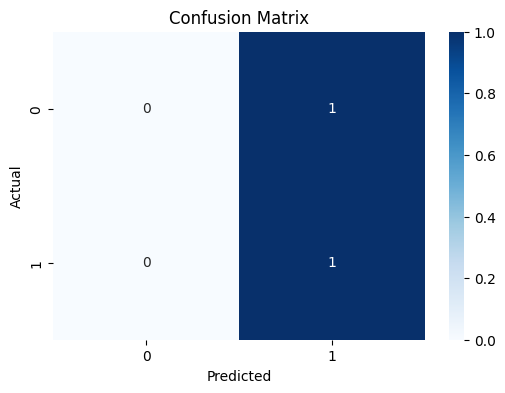

In [13]:
plot_confusion_matrix(y_true, y_pred)